# Train ML Model
I am going to have an explore and see what is best though, as usual, I expect XGBoost will be all conquering for this discussion because again we are working with tabular data. I will read it in using Polars this time for performance reasons.

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import xgboost as xgb
from xgboost import Booster
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
hep.style.use(hep.style.ROOT)

In [2]:
from typing import Tuple

def precision_metric(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    """ Custom evaluation metric for XGBoost to display during training """
    label = dtrain.get_label()
    # Use a nominal threshold of 0.2
    preds_binary = (predt > 0.2).astype(int)
    precision = np.sum((preds_binary == 1) & (label == 1)) / np.sum(preds_binary)
    return 'Precision', precision

def fbeta(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    """ Custom evaluation metric for XGBoost to display during training """
    label = dtrain.get_label()
    beta = 0.5 # Precision matters twice as much as recall (i.e. F0.5 score, don't like false positives)
    threshold = 0.2
    tp = np.count_nonzero((predt > threshold) & (label == 1))
    fp = np.count_nonzero((predt > threshold) & (label == 0))
    fn = np.count_nonzero((predt <= threshold) & (label == 1))

    fbeta = ((1+beta**2) * (tp)) / (((1+beta**2) * tp) + (beta**2 * fn) + fp)
    return 'F(beta=0.5)', fbeta

In [3]:
def missing_mass_plot(df):
    plt.clf()
    plt.figure(figsize=(7, 6))
    h, xbins, ybins = np.histogram2d(df["p"].to_numpy(), df["mm2"].to_numpy(), bins=(np.linspace(10, 50, 41), np.linspace(-0.05, 0.1, 300)))
    hep.hist2dplot(h, xbins, ybins, cmap="jet", norm=LogNorm())
    plt.grid()
    plt.tight_layout()
    plt.show()

In [4]:
column_names = [
    "straw1x", "straw1y", "trim5x", "trim5y", "tktag", "tgtk", "trich",
    "mm2rich", "mm2nom", "mm2", "p", "prich", "vtxz", "vtxx", "vtxy",
    "thetax", "thetay", "rstraw1", "nktaghits", "ngtkhits",
    "region", "isUpstreamTMVA",
    "pKaon", "gtk3x", "gtk3y", "gtk2x", "gtk2y", "gtkHitsWord",
]

## Defining Features
For the time being I will use the exact same set of features and the same training sets as the ROOT TMVA that is currently implemented. Then we can evaluate the performance differences if any and start tuning from this baseline.

In [5]:
features = [
    "straw1x", "straw1y", "trim5x", "trim5y", "rstraw1", "vtxz", "vtxx", "vtxy", "thetax", "thetay",
]

In [6]:
signal = pl.read_csv("data/kaonTree/BDT_KpinnNoov_Train_KaonTree_NewVtx.txt", has_header=True)
bkg = pl.read_csv("data/kaonTree/BDT_2022_Train_KaonTree_NewVtx.txt", has_header=True)

Constrain the background sample to the signal region (should actually be done on the analyser level, this was an oversight).

In [152]:
pl.Series(bkg.select("region")).value_counts() # We can see the background is drawn only from the signal regions

region,count
i64,u32
1,35
2,8021


<Figure size 1000x1000 with 0 Axes>

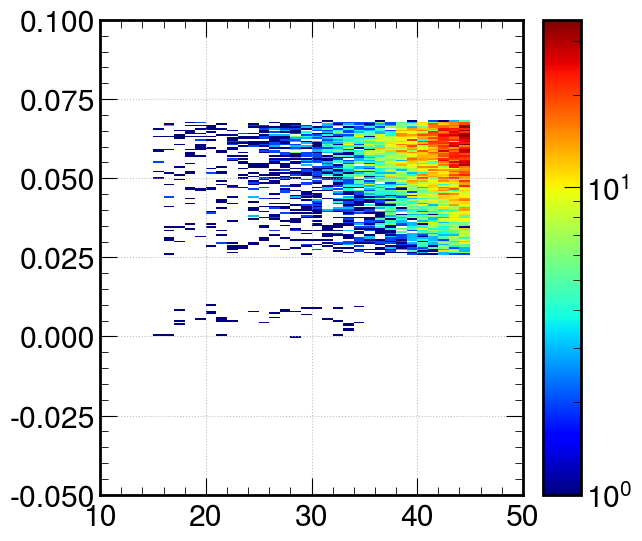

In [153]:
missing_mass_plot(bkg)

<Figure size 1000x1000 with 0 Axes>

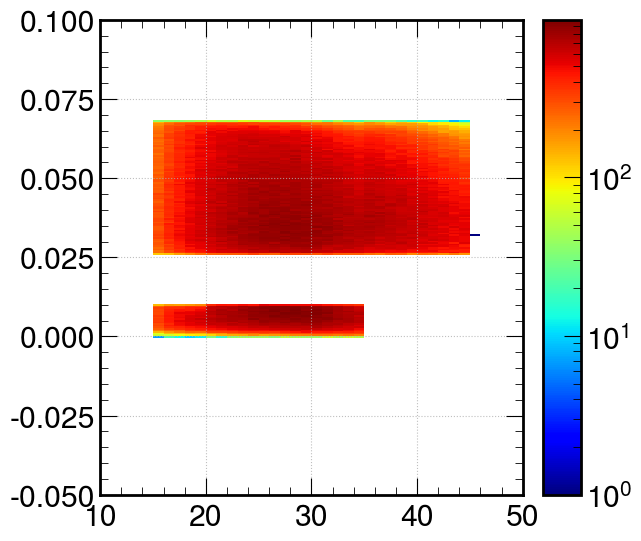

In [154]:
missing_mass_plot(signal)

## Making Training Samples

In [7]:
# Add target indicators
signal = signal.with_columns(pl.lit(1).alias('isSignal'))
bkg = bkg.with_columns(pl.lit(0).alias('isSignal'))
# Combine the dataframes together
df = pl.concat([signal, bkg], how='vertical')

In [8]:
# Add special features to df
df = df.with_columns(pl.lit(np.sqrt((df['straw1x']**2 + df['straw1y']**2)) - np.sqrt((df['gtk3x']**2 + df['gtk3y']**2))).alias('drs1gtk3'))

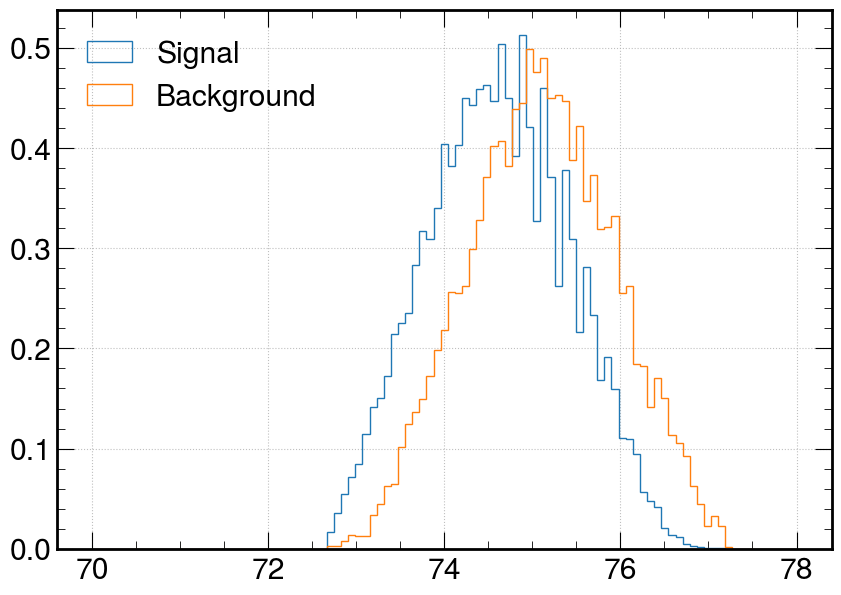

In [9]:
bins = np.linspace(70, 78, 100)
plt.figure(figsize=(10,7))
plt.hist(df.filter(pl.col("isSignal").eq(1))["pKaon"], bins=bins, histtype='step', density=True, label="Signal")
plt.hist(df.filter(pl.col("isSignal").eq(0))["pKaon"], bins=bins, histtype='step', density=True, label="Background")
plt.grid()
plt.legend()
plt.show()

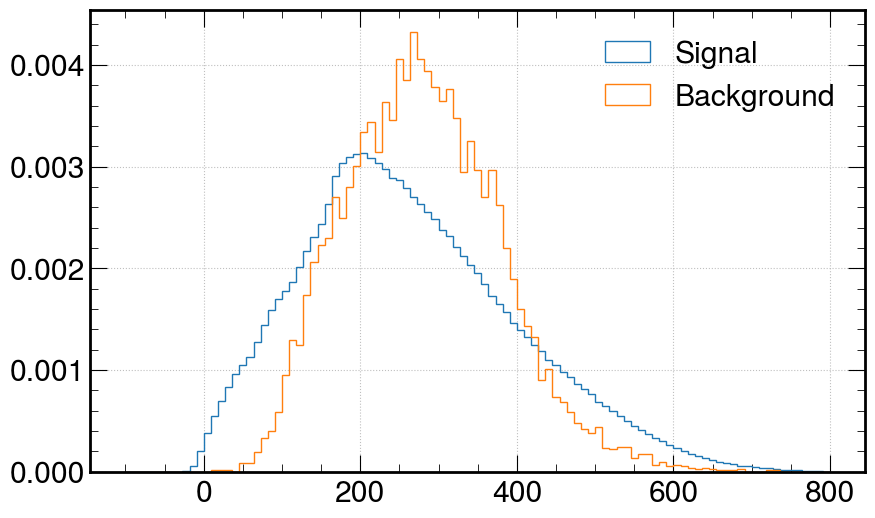

In [10]:
bins = np.linspace(-100, 800, 100)
plt.figure(figsize=(10,6))
plt.hist(df.filter(pl.col("isSignal").eq(1))["drs1gtk3"], bins=bins, histtype='step', density=True, label="Signal")
plt.hist(df.filter(pl.col("isSignal").eq(0))["drs1gtk3"], bins=bins, histtype='step', density=True, label="Background")
plt.grid()
plt.legend()
plt.show()

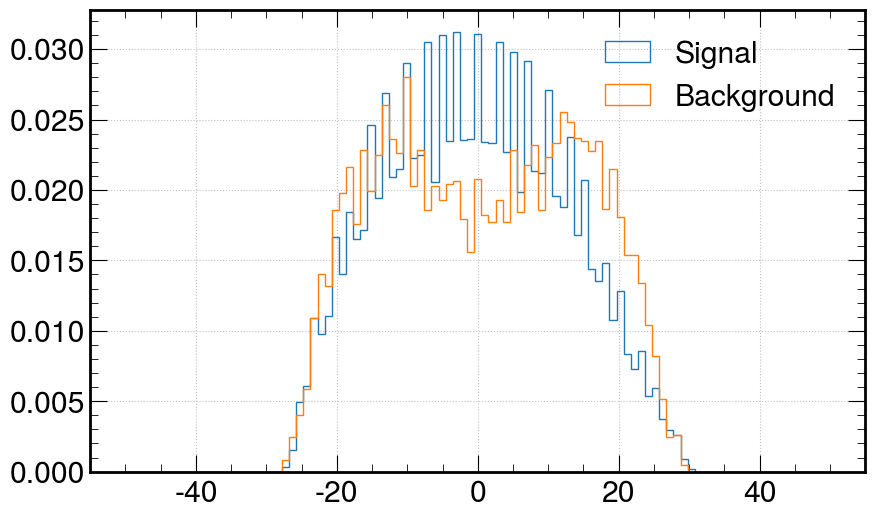

In [11]:
bins = np.linspace(-50, 50, 100)
plt.figure(figsize=(10,6))
plt.hist(df.filter(pl.col("isSignal").eq(1))["gtk3x"], bins=bins, histtype='step', density=True, label="Signal")
plt.hist(df.filter(pl.col("isSignal").eq(0))["gtk3x"], bins=bins, histtype='step', density=True, label="Background")
plt.grid()
plt.legend()
plt.show()

In [12]:
# Compute weights to combat class imbalance
X_train, X_test, y_train, y_test = train_test_split(df.drop("isSignal"), df["isSignal"], test_size=0.1, random_state=42)
classes_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
weights = np.array([classes_weights[sampleClass] for sampleClass in y_train])

In [13]:
# Add new features to the list of features
features += ["pKaon", "gtk3x", "gtk3y"] # "pprich", "pKaon", "gtk3x", "gtk3y" drs1gtk3
#features.append("dmm2nom")
#features.append("dmm2rich")
#features += ["ngtkhits"] 
print(features)

['straw1x', 'straw1y', 'trim5x', 'trim5y', 'rstraw1', 'vtxz', 'vtxx', 'vtxy', 'thetax', 'thetay', 'pKaon', 'gtk3x', 'gtk3y']


## Training a Classifier

In [162]:
# Convert data to DMatrix
dtrain = xgb.DMatrix(X_train[features].to_numpy(), label=y_train.to_numpy(), weight=weights)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.15, # should probably drop this slightly and move to increase boosting rounds
    'max_depth': 6,
    'reg_alpha': 1,
    'reg_lambda': 1,
    'seed': 0,
}

# Train the XGBoost model
num_round = 70 # About 55-75 seems like the sweetspot
evals = [(dtrain, 'train')]
model = xgb.train(params, dtrain, num_round, evals=evals, verbose_eval=5, early_stopping_rounds=5)

[0]	train-logloss:0.57284
[5]	train-logloss:0.28004
[10]	train-logloss:0.17381
[15]	train-logloss:0.12577
[20]	train-logloss:0.10119
[25]	train-logloss:0.08424
[30]	train-logloss:0.07282
[35]	train-logloss:0.06605
[40]	train-logloss:0.06178
[45]	train-logloss:0.05700
[50]	train-logloss:0.05378
[55]	train-logloss:0.05130
[60]	train-logloss:0.04753
[65]	train-logloss:0.04501
[69]	train-logloss:0.04412


In [163]:
model.save_model("models/kaon4.xgb") # TODO: Change this name

## Evaluate Training

In [5]:
model = Booster()
model.load_model("models/kaon4.xgb")

In [165]:
pred_proba_test = model.predict(xgb.DMatrix(X_test[features].to_numpy().astype(np.float64)))
pred_proba_train = model.predict(xgb.DMatrix(X_train[features].to_numpy().astype(np.float64)))

In [166]:
f1_test = f1_score(y_test.to_numpy().astype(np.float64), pred_proba_test > 0.03)
f1_train = f1_score(y_train.to_numpy().astype(np.float64), pred_proba_train > 0.03)
print("F1 Score (Test@0.99): ", f1_test)
print("F1 Score (Train@0.99): ", f1_test)

F1 Score (Test@0.99):  0.9983026925744322
F1 Score (Train@0.99):  0.9983026925744322


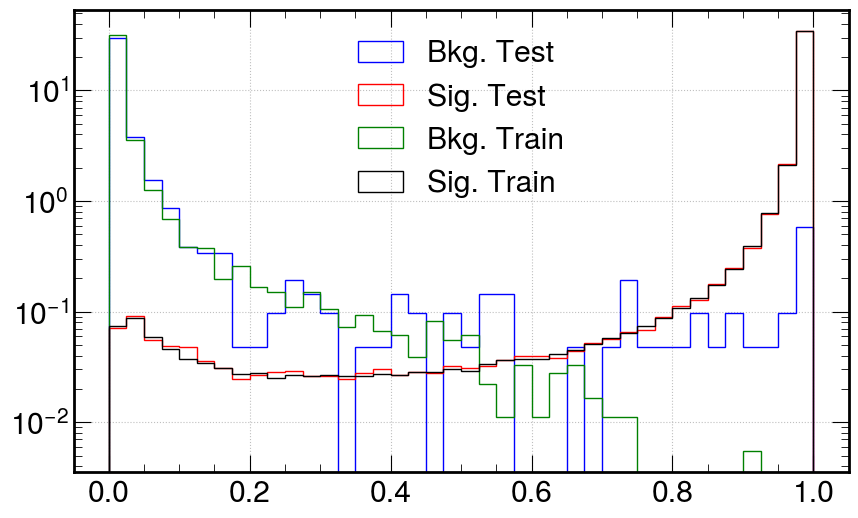

In [167]:
plt.figure(figsize=(10, 6))
plt.hist(pred_proba_test[y_test == 0], bins=np.linspace(0,1,41), histtype='step', label='Bkg. Test', color='b', density=True)
plt.hist(pred_proba_test[y_test == 1], bins=np.linspace(0,1,41), histtype='step', label='Sig. Test', color='r', density=True)
plt.hist(pred_proba_train[y_train == 0], bins=np.linspace(0,1,41), histtype='step', label='Bkg. Train', color='g', density=True)
plt.hist(pred_proba_train[y_train == 1], bins=np.linspace(0,1,41), histtype='step', label='Sig. Train', color='k', density=True)
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

Peakiing structure at the high-tail of the background distribution implies mechanisms we can't fully describe with the inputs provided..

Let's have a look at the impact on the missing mass spectrum at a decision boundary of 0.2 for the test events which are background-like.

In [168]:
# Add truth labels to X frames
X_test = X_test.with_columns(pl.lit(y_test).alias('isSignal'))
X_train = X_train.with_columns(pl.lit(y_train).alias('isSignal'))

In [169]:
X_test = X_test.with_columns(pl.Series("pred", pred_proba_test))
X_train = X_train.with_columns(pl.Series("pred", pred_proba_train))

In [170]:
def get_fpr(conf_matrix):
    return conf_matrix[0][1] / np.sum(conf_matrix[0])

def get_fnr(conf_matrix):
    return conf_matrix[1][0] / np.sum(conf_matrix[1])

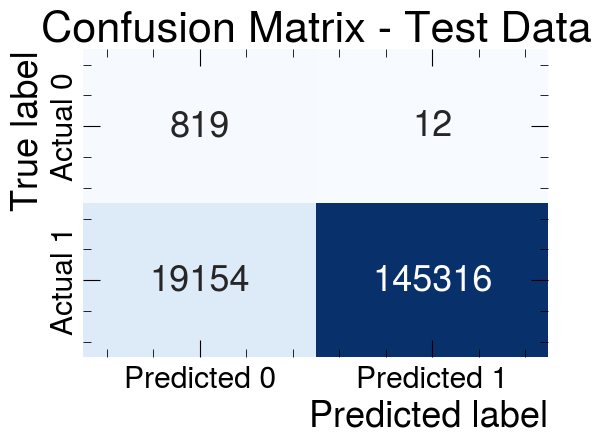

In [171]:
# Now lets get the raw counts via a confusion matrix and a custom deicision boundary
conf_matrix = confusion_matrix(y_test.to_numpy().astype(np.float64), pred_proba_test > 0.97)
#sns.set(font_scale=1.4)  # Adjust the font scale for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Test Data')
plt.show()

In [172]:
print(f"False positive rate = {get_fpr(conf_matrix):.6f}")
print(f"False negative rate = {get_fnr(conf_matrix):.6f}")

False positive rate = 0.014440
False negative rate = 0.116459


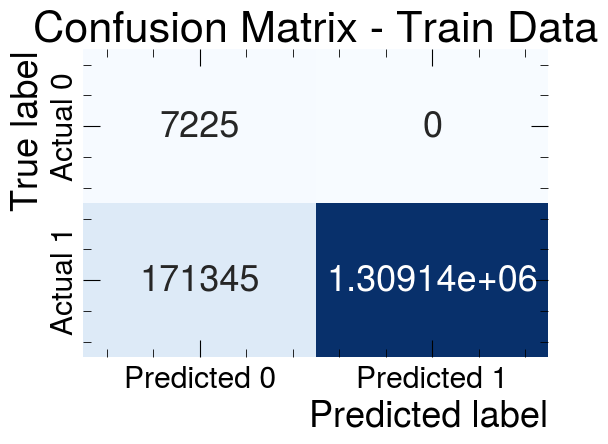

In [173]:
# Now lets get the raw counts via a confusion matrix and a custom deicision boundary
conf_matrix = confusion_matrix(y_train.to_numpy().astype(np.float64), pred_proba_train > 0.97)
#sns.set(font_scale=1.4)  # Adjust the font scale for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Train Data')
plt.show()

In [174]:
print(f"False positive rate = {get_fpr(conf_matrix):.6f}")
print(f"False negative rate = {get_fnr(conf_matrix):.6f}")

False positive rate = 0.000000
False negative rate = 0.115736


Evidence of overtraining from the confusion matrices, however the changes to the parameters were a step in the correct direction.

## Evaluation Samples
We need a good reference point to see how the models (both) perform. I will do this using the full signal selection with only the current BDT cut not applied for Kpinn non-overlaid MC. We are looking for direct increases/stability in this count. 

Then of major importance is how we look in data. Obvioulsy the training and testing samples can only show us so much. These training samples are constrained to the signal region and are very much like the signal selection except that:
1. No GTK extra hits veto is applied (inside of IsUpstream)
2. Out-of-time
3. CDA > 4 mm to replace standard K-pi matching conditions.

Note our signal training sample is the full signal selection excluding the veto counter and trapezoid cut.

To actually test we define some different background samples, constrained again to the signal region and has the signal selection other than:
1. Require hits in the VC and a large CDA.
2. A large CDA and outside of the trapezoid in $R_{STRAW1}$ versus $Z_{vtx}$ space.

In [175]:
# Cleanup memory
del X_test, X_train, y_test, y_train, signal, bkg, df

In [14]:
model = Booster()
model.load_model("models/kaon4.xgb")

In [6]:
sigEval = pl.read_csv("data/kaonTree/BDT_KpinnNoov_Eval_KaonTree_NewVtx.txt", has_header=True)
bkgEval = pl.read_csv("data/kaonTree/BDT_2022_BkgRegions_KaonTree_NewVtx.txt", has_header=True)
sampleC = pl.read_csv("data/kaonTree/BDT_2022_SampleC_KaonTree_NewVtx.txt", has_header=True)

In [11]:
def add_col(df):
    df = df.with_columns(pl.lit(np.sqrt((df['straw1x']**2 + df['straw1y']**2)) - np.sqrt((df['gtk3x']**2 + df['gtk3y']**2))).alias('drs1gtk3'))
    return df

sigEval = add_col(sigEval)
bkgEval = add_col(bkgEval)
sampleC = add_col(sampleC)

The current acceptance of signal for the current TMVA, recall this is non-overlaid. Recall when we have a "1" in isUpsTMVA it is because the BDT believes the event is upstream-like and so will be vetoed.

In [182]:
sigProba = model.predict(xgb.DMatrix(sigEval[features].to_numpy().astype(np.float64)))
bkgProba = model.predict(xgb.DMatrix(bkgEval[features].to_numpy().astype(np.float64)))
saCProba = model.predict(xgb.DMatrix(sampleC[features].to_numpy().astype(np.float64)))

# Add predictions onto each frame
sigEval = sigEval.with_columns(pl.Series("pred", sigProba))
bkgEval = bkgEval.with_columns(pl.Series("pred", bkgProba))
sampleC = sampleC.with_columns(pl.Series("pred", saCProba))

### Signal Acceptances
We look at the signal acceptance both within and outside the signal regions.

In [183]:
sigAccTMVA = (len(sigEval) - np.count_nonzero(sigEval.select("isUpstreamTMVA"))) / len(sigEval)
sigAccBDT = np.count_nonzero(sigEval.select("pred") > 0.975) / len(sigEval)

print("---- Signal (Noov) SR Only ----")
print(f"Signal acceptance (TMVA) = {sigAccTMVA*100:.2f}%")
print(f"Signal acceptance (BDT) = {sigAccBDT*100:.2f}%")

---- Signal (Noov) SR Only ----
Signal acceptance (TMVA) = 83.46%
Signal acceptance (BDT) = 86.78%


In [184]:
bkgAccTMVA = (len(bkgEval) - np.count_nonzero(bkgEval.select("isUpstreamTMVA"))) / len(bkgEval)
bkgAccBDT = np.count_nonzero(bkgEval.select("pred") > 0.975) / len(bkgEval)

print("---- All kinematic regions ----")
print(f"Bkg1 acceptance (TMVA) = {bkgAccTMVA*100:.2f}%")
print(f"Bkg1 acceptance (BDT) = {bkgAccBDT*100:.2f}%")

---- All kinematic regions ----
Bkg1 acceptance (TMVA) = 83.04%
Bkg1 acceptance (BDT) = 79.51%


In [191]:
# K3pi = 5, Kmu2 = 4, K2pi = 3  
print(np.count_nonzero(bkgEval.filter(
    pl.col("region").eq(3) # K3pi region
).select("pred") > 0.975))

print(np.count_nonzero(bkgEval.filter(
    pl.col("region").eq(3) # K3pi region
).select("isUpstreamTMVA") == 0))

2927
3152


In [187]:
n0 = (len(sampleC) - np.count_nonzero(sampleC.select("isUpstreamTMVA")))
sampleCAccTMVA = n0 / len(sampleC)

n1 = np.count_nonzero(sampleC.select("pred") > 0.975)
sampleCAccBDT = n1 / len(sampleC)

print("---- SampleC (All kinematic regions) ----")
print(f"Bkg1 acceptance (TMVA) = {sampleCAccTMVA*100:.2f}% (N={n0})")
print(f"Bkg1 acceptance (BDT) = {sampleCAccBDT*100:.2f}% (N={n1})")

---- SampleC (All kinematic regions) ----
Bkg1 acceptance (TMVA) = 17.97% (N=2302)
Bkg1 acceptance (BDT) = 15.93% (N=2041)


In [188]:
sampleCSR = sampleC.filter(
    pl.col("region").eq(1) | pl.col("region").eq(2)
)

n0 = (len(sampleCSR) - np.count_nonzero(sampleCSR.select("isUpstreamTMVA")))
sampleCTMVA = n0 / len(sampleCSR)

n1 = np.count_nonzero(sampleCSR.select("pred") > 0.975)
sampleCBDT = n1 / len(sampleCSR)

print("---- SampleC (Signal regions) ----")
print(f"Bkg1 acceptance (TMVA) = {sampleCTMVA*100:.2f}% (N={n0})")
print(f"Bkg1 acceptance (BDT) = {sampleCBDT*100:.2f}% (N={n1})")

---- SampleC (Signal regions) ----
Bkg1 acceptance (TMVA) = 2.41% (N=56)
Bkg1 acceptance (BDT) = 2.02% (N=47)


In [194]:
features, len(features)

(['straw1x',
  'straw1y',
  'trim5x',
  'trim5y',
  'rstraw1',
  'vtxz',
  'vtxx',
  'vtxy',
  'thetax',
  'thetay',
  'pKaon',
  'gtk3x',
  'gtk3y'],
 13)

# Old Stuff Below

### Background Acceptances 1 -- Large CDA and VC hits
Again we look at the two base samples to start with. For a final evaluation we can use sampleC and the entire of 2022 with the standard signal selection (obviously changing the TMVA for the BDT).

In [203]:
bkgAccTMVA = (len(bkgEval) - np.count_nonzero(bkgEval.select("isUpsTMVA"))) / len(bkgEval)
bkgAccBDT = np.count_nonzero(bkgEval.select("pred") > 0.993) / len(bkgEval)

print("---- All kinematic regions ----")
print(f"Bkg1 acceptance (TMVA) = {bkgAccTMVA*100:.2f}%")
print(f"Bkg1 acceptance (BDT) = {bkgAccBDT*100:.2f}%")

---- All kinematic regions ----
Bkg1 acceptance (TMVA) = 2.31%
Bkg1 acceptance (BDT) = 1.86%


In [204]:
bkgEvalSR = bkgEval.filter(
    (pl.col("region").eq(1)) | (pl.col("region").eq(2))
)

In [205]:
# Now constrian to just the signal regions
nSignalRegion = len(bkgEvalSR)

bkgAccTMVA = (nSignalRegion - np.count_nonzero(bkgEvalSR.select("isUpsTMVA"))) / nSignalRegion
bkgAccBDT = np.count_nonzero(bkgEvalSR.select("pred") > 0.993) / nSignalRegion

print("---- Signal regions only ----")
print(f"Bkg1 acceptance (TMVA) = {bkgAccTMVA*100:.2f}%")
print(f"Bkg2 acceptance (BDT) = {bkgAccBDT*100:.2f}%")

---- Signal regions only ----
Bkg1 acceptance (TMVA) = 1.16%
Bkg2 acceptance (BDT) = 0.93%


This is actually a change of about -10% relative, with no change in the signal acceptance.

In [206]:
print("N(BDT,SR) = ", np.count_nonzero(bkgEvalSR.select("pred") > 0.993)) # Number of background events BDT wrongly accepts as signal (in SR)
print("N(TMVA,SR) = ", (nSignalRegion - np.count_nonzero(bkgEvalSR.select("isUpsTMVA")))) # Number of background events TMVA wrongly accepts as signal (in SR)

45
56


### Background Evaluation 2 - Large CDA and under the trapezoid

In [207]:
bkgEval2 = pl.read_csv("data/eval/BDT_Eval_2022_Bkg2.txt", has_header=False)
bkgEval2 = bkgEval2.drop("column_23")
bkgEval2.columns = column_names

# Feature engineering (add new features)
bkgEval2 = bkgEval2.with_columns(pl.lit((bkgEval2.select("p") - bkgEval2.select("prich")).to_numpy().flatten()).alias("pprich"))
bkgEval2 = bkgEval2.with_columns(pl.lit((bkgEval2.select("mm2") - bkgEval2.select("mm2nom")).to_numpy().flatten()).alias("dmm2nom"))
bkgEval2 = bkgEval2.with_columns(pl.lit((bkgEval2.select("mm2") - bkgEval2.select("mm2rich")).to_numpy().flatten()).alias("dmm2rich"))
bkgProba2 = model.predict(xgb.DMatrix(bkgEval2[features].to_numpy().astype(np.float64)))
bkgEval2 = bkgEval2.with_columns(pl.Series("pred", bkgProba2))

In [208]:
bkgEval2[features][0]

straw1x,straw1y,trim5x,trim5y,rstraw1,vtxz,vtxx,vtxy,thetax,thetay
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
77.4241,103.164,39.0366,9.96858,105.868,112.165,26.5656,8.52974,0.000464,0.001136


In [209]:
model.predict(xgb.DMatrix(bkgEval2[features][0].to_numpy().astype(np.float64)))

array([0.00433965], dtype=float32)

In [210]:
len(bkgEval2.filter(pl.col("region").eq(1) | pl.col("region").eq(2))) # Clearly insufficient statistics to only look at the signal region

11

In [211]:
bkgAccTMVA = (len(bkgEval2) - np.count_nonzero(bkgEval2.select("isUpsTMVA"))) / len(bkgEval2)
bkgAccBDT = np.count_nonzero(bkgEval2.select("pred") > 0.99) / len(bkgEval2)

print("---- All kinematic regions ----")
print(f"Bkg2 acceptance (TMVA) = {bkgAccTMVA*100:.2f}%")
print(f"Bkg2 acceptance (BDT) = {bkgAccBDT*100:.2f}%")

---- All kinematic regions ----
Bkg2 acceptance (TMVA) = 0.00%
Bkg2 acceptance (BDT) = 0.00%


### SampleC

In [212]:
sampleC = pl.read_csv("data/eval/BDT_Eval_SampleC_SROnly.txt", has_header=False)
sampleC = sampleC.drop("column_23")
sampleC.columns = column_names
sampleC = sampleC.with_columns(pl.lit(sampleC["p"] - sampleC["prich"]).alias("pprich"))
probSampleC = model.predict(xgb.DMatrix(sampleC[features].to_numpy().astype(np.float64)))
sampleC = sampleC.with_columns(pl.Series("pred", probSampleC))

In [217]:
print(f"Number of events in SampleC (all regions)   = {len(sampleC)}")
print(f"Number of events in SampleC (signal regions) = {len(sampleC.filter(pl.col('region').eq(1) | pl.col('region').eq(2)))}")

Number of events in SampleC (all regions)   = 12949
Number of events in SampleC (signal regions) = 2351


In [218]:
print(f'Number of events remaining in sampleC (TMVA): {len(sampleC) - np.count_nonzero(sampleC.select("isUpsTMVA"))}')
print(f'Number of events remaining in sampleC (BDT): {np.count_nonzero(sampleC.select("pred") > 0.993)}')

Number of events remaining in sampleC (TMVA): 2329
Number of events remaining in sampleC (BDT): 2195


In [219]:
sampleCSR = sampleC.filter(
    pl.col('region').eq(1) | pl.col('region').eq(2)
)

In [220]:
print(f'Number of events remaining in SR sampleC (TMVA): {len(sampleCSR) - np.count_nonzero(sampleCSR.select("isUpsTMVA"))}')
print(f'Number of events remaining in SR sampleC (BDT): {np.count_nonzero(sampleCSR.select("pred") > 0.993)}')

Number of events remaining in sampleC (TMVA): 56
Number of events remaining in sampleC (BDT): 63


## Feature Rankings
So clearly both the baselin3 and baseline5 models are extremely strong candidates, 5 especially so but i want to be careful of any data leaks!

<Figure size 1000x1000 with 0 Axes>

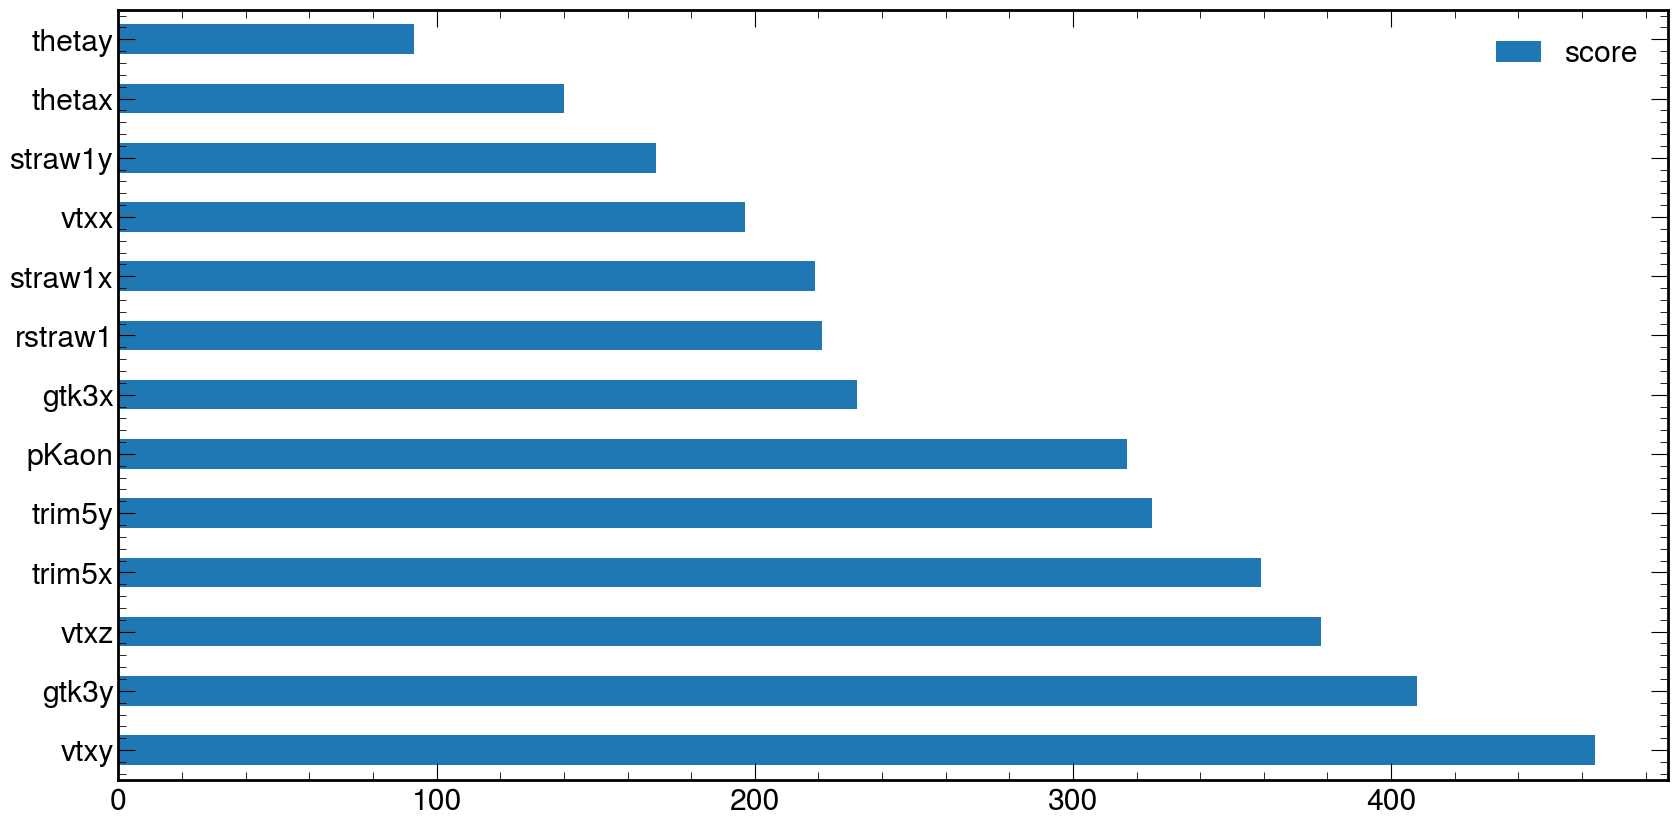

In [192]:
feature_important = model.get_score(importance_type='weight')
keys = list(feature_important.keys())
keys = [features[int(i[1:])] for i in keys]
values = list(feature_important.values())

fig = plt.figure()
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(features), columns="score").plot(kind='barh', figsize = (20,10)) ## plot
plt.show()

## Feature Understanding

In [17]:
import shap

In [23]:
# Take a typical signal event
Xd = xgb.DMatrix(X_test[features])

pred = model.predict(Xd, output_margin=True)

explainer = shap.TreeExplainer(model, feature_names=features)
explanation = explainer(X_test[features].to_numpy())

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

4.7683716e-06

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


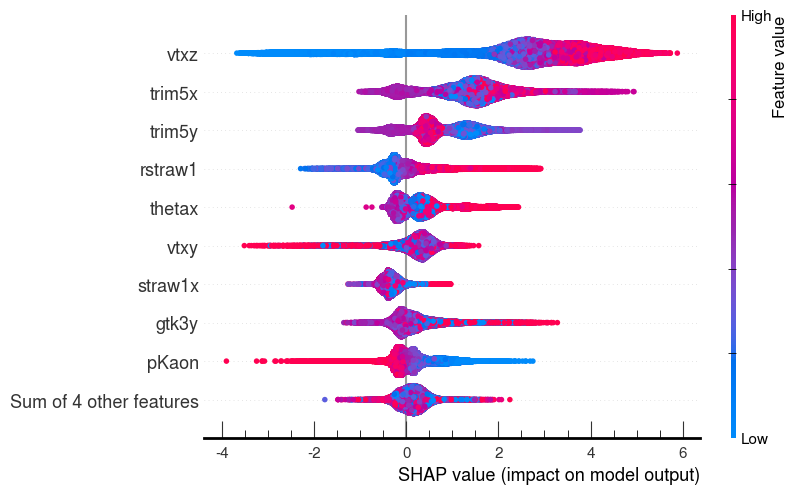

In [24]:
shap.plots.beeswarm(explanation)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


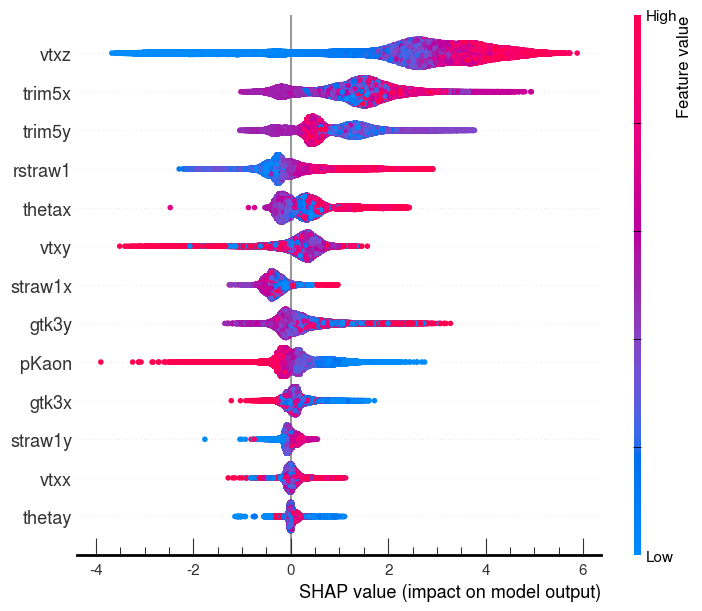

In [28]:
shap.summary_plot(shap_values, X_test[features].to_numpy(), feature_names=features)

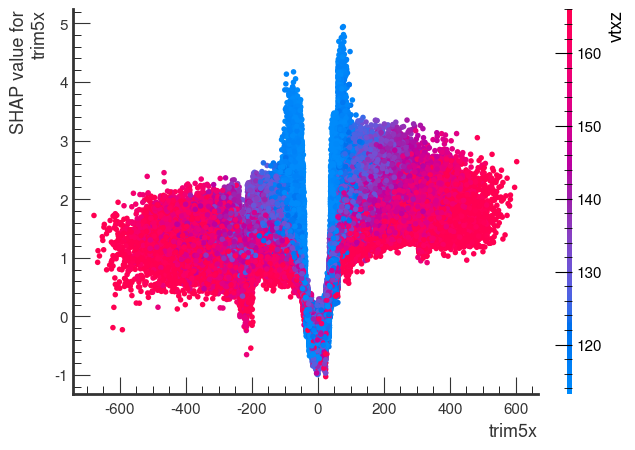

In [30]:
shap.dependence_plot(2, shap_values, X_test[features].to_numpy(), feature_names=features)

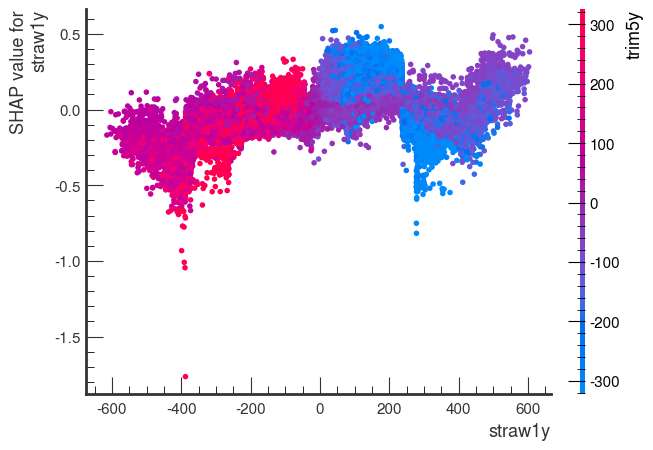

In [31]:
shap.dependence_plot(1, shap_values, X_test[features].to_numpy(), feature_names=features)

## Visualise Tree

In [1]:
def plot_tree(xgb_model, filename, tree_num=None, rankdir='UT'):
    """
    Plot the tree in high resolution
    :param xgb_model: xgboost trained model
    :param filename: the pdf file where this is saved
    :param rankdir: direction of the tree: default Top-Down (UT), accepts:'LR' for left-to-right tree
    :return:
    """
    import xgboost as xgb
    import os
    if tree_num == None:
        tree_num = xgb_model.best_iteration
    gvz = xgb.to_graphviz(xgb_model, num_trees=tree_num, rankdir=rankdir)
    _, file_extension = os.path.splitext(filename)
    format = file_extension.strip('.').lower()
    data = gvz.pipe(format=format)
    full_filename = filename
    with open(full_filename, 'wb') as f:
        f.write(data)

In [36]:
plot_tree(model, "tree_best.pdf")

In [37]:
features

['straw1x',
 'straw1y',
 'trim5x',
 'trim5y',
 'rstraw1',
 'vtxz',
 'vtxx',
 'vtxy',
 'thetax',
 'thetay',
 'pKaon',
 'gtk3x',
 'gtk3y']